In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
import datajoint as dj
import numpy as np
import os
from stimulus import stimulus
from pipeline import fuse, experiment

import monet_trippy as mt
import random

Connecting dimitri@at-database.ad.bcm.edu:3306
Loading local settings from pipeline_config.json


In [3]:
schema = dj.schema('dimitri_debug')

In [5]:
@schema 
class Discrepancy(dj.Computed):
    definition = """
    -> stimulus.Trial
    ---
    discrepancy : float   # difference between recorded vs displayed frames
    """
    
    key_source = experiment.Scan & (stimulus.Trial * stimulus.Trippy)
    
    def make(self, key):
        keys, duration, fps, times = (stimulus.Trippy * stimulus.Trial & key).fetch('KEY', 'duration', 'fps', 'flip_times', squeeze=True)
        self.insert((dict(k, discrepancy=float(d)*float(f) - t.size)
                    for k, d, f, t in zip(keys, duration, fps, times)), ignore_extra_fields=True)

In [6]:
Discrepancy.populate(display_progress=True)

100%|██████████| 63/63 [00:44<00:00,  1.11s/it]


In [15]:
(Discrepancy() & 'animal_id = 0').delete()

About to delete:
`dimitri_debug`.`__discrepancy`: 2404 items
Proceed? [yes, No]: yes
Committed.


In [21]:
k = np.random.choice(((Discrepancy & 'discrepancy') & (stimulus.Trial*stimulus.Trippy)).fetch('KEY'))

In [8]:
%matplotlib inline
from matplotlib import pyplot as plt

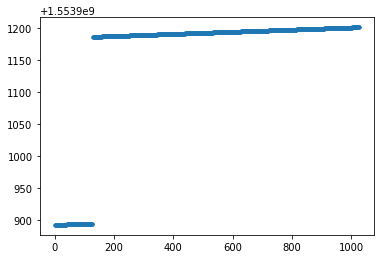

In [22]:
plt.plot(((stimulus.Trial & k).fetch1('flip_times').flatten()), '.')For 

In [ ]:
# sessions that have both Monet and Trippy from a few recent experiments
sessions = (fuse.Activity * stimulus.Sync & 'animal_id in (20505, 20322, 20457, 20210, 20892)'
            & (stimulus.Trial * stimulus.Monet2) & (stimulus.Trial * stimulus.Trippy)).fetch('KEY')
key = sessions[2]   # pick one
session_name = dj.hash.key_hash(key)[:6]

In [ ]:
keys = (stimulus.Monet2 * stimulus.Trial & 'animal_id between 17000 and 18000').fetch('KEY')

In [ ]:
key = random.choice(keys)
g = (stimulus.Monet2 * stimulus.Trial & key).fetch1('flip_times', 'duration', 'fps', 'movie')

In [ ]:
d, t, n = (experiment.Session * stimulus.Monet2 * stimulus.Trial & 'animal_id > 18000').proj(
     'session_date', 'flip_times', nframes='duration*fps').fetch('session_date', 'flip_times', 'nframes')

In [ ]:
q = np.array(list((d_, t_.size, n_) for d_, t_, n_ in zip(d, t, n)))

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 3))
ax.plot(q[:,0], q[:,1]- q[:,2], '.')
ax.set_ylabel('Monet2 frame discrepancy')

In [ ]:
help(plt.subplots)

In [ ]:
experiment.Session()

In [ ]:
# Load frame times
pipe = (fuse.Activity() & key).module
num_frames = (pipe.ScanInfo() & key).fetch1('nframes')
num_depths = len(dj.U('z') & (pipe.ScanInfo.Field().proj('z', nomatch='field') & key))
frame_times = (stimulus.Sync() & key).fetch1('frame_times', squeeze=True) # one per depth
assert num_frames <= frame_times.size / num_depths <= num_frames + 1
frame_times = frame_times[:num_depths * num_frames:num_depths]  # one per volume

In [ ]:
# Load and cache soma traces
trace_hash = dj.hash.key_hash({k: v for k, v in key.items() if k not in {'stimulus_type'}})
archive = os.path.join('cache', trace_hash + '-traces.npz')
if os.path.isfile(archive):
    data = np.load(archive)
    trace_keys = data['trace_keys']
    traces = data['traces']
    ms_delay = data['ms_delay']
else:
    units = pipe.ScanSet.Unit * pipe.MaskClassification.Type & {'type': 'soma'}
    spikes = pipe.Activity.Trace * pipe.ScanSet.UnitInfo & units & key
    trace_keys, traces, ms_delay = spikes.fetch('KEY', 'trace', 'ms_delay')
    np.savez_compressed(archive, trace_keys=trace_keys, traces=traces, ms_delay=ms_delay)
frame_times = np.add.outer(ms_delay / 1000, frame_times)  # num_traces x num_frames

In [ ]:
trippy_session = mt.VisualSession(np.stack(traces), frame_times)
for trial in (stimulus.Trial * stimulus.Condition * stimulus.Trippy & key).proj(..., '- movie'):
    trippy_session.add_trial(mt.Trippy.from_condition(trial), trial['flip_times'].flatten())

In [ ]:
trippy_session.save(session_name)

In [ ]:
'%08.3f' % (trippy_session.trials[0]['times'][0] - trippy_session.times.flatten()[0])

In [ ]:
session_name

In [ ]:
help(os.makedirs)

In [ ]:
json.dumps(()

In [ ]:
trippy_session.trials[0]['times'][0]

In [ ]:
import os
import hashlib

In [ ]:
help(hashlib.blake2b)

In [ ]:
os.path.abspath('../data')

In [ ]:
help(os.makedirs)

In [ ]:
help(np.savez)